In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from matplotlib import style
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
style.use('ggplot')
%matplotlib inline
warnings.filterwarnings('ignore')

## Полезные функции

In [2]:
def categoral(column):
    fig = plt.figure(figsize=(14, 4))   
    ax1 = fig.add_axes([0, 0, 0.8, 1])
    plt.title('Соотношение клиентов банка по категориям '+column)
    ax = sns.countplot(x=column, hue="default", data=train)
    num = len(train[column].value_counts())
    a = [p.get_height() for p in ax.patches]
    patch = [p for p in ax.patches]
    for i in range(num):
        for j in range(2):
            percentage = '{:.1f}%'.format(100 * a[(j*num + i)]/(a[i]+a[i+num]))
            x = patch[(j*num + i)].get_x() + patch[(j*num + i)].get_width() / 2 - 0.15
            y = patch[(j*num + i)].get_y() + patch[(j*num + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)
    plt.show()    
    ax2 = fig.add_axes([0, 0, 0.5, 1])
    data[column].value_counts().plot.bar()
    plt.title('Распределение признака '+column+' по категориям')
    plt.tight_layout()

    
def numeral(column):
    fig = plt.figure(figsize=(14, 4))
    ax1 = fig.add_axes([0, 0.4, 0.45, 1])
    plt.title('Распределение признака '+column+' в train по типам клиентов банка')
    sns.histplot(data=train[column], x=train[column], hue=train['default'])
    plt.legend(['negative', 'positive'])
    ax2 = fig.add_axes([0, 0, 0.45, 0.25])
    sns.boxplot(y='default', x=column,data=train[train['Train'] == 1], orient='h', saturation=0.5)
    ax3 = fig.add_axes([0.55, 0.4, 0.45, 1])
    plt.title('Распределение признака '+column+' в датасетах')
    sns.histplot(data=data[column], x=data[column], hue=data['Train'])
    plt.legend(['train', 'test'])
    ax4 = fig.add_axes([0.55, 0, 0.45, 0.25])
    sns.boxplot(y='Train', x=column, data=data, orient='h', saturation=0.5)
    plt.tight_layout()
    
    
def numeral_prolog(column):
    fig = plt.figure(figsize=(14, 4))
    ax1 = fig.add_axes([0.55, 0.4, 0.45, 1])
    plt.title('Распределение прологарифмированного признака ' + column+' в двух датасетах')
    sns.histplot(data=data[column], x=data[column], hue=data['Train'])
    plt.legend(['train', 'test'])
    ax2 = fig.add_axes([0.55, 0, 0.45, 0.25])
    sns.boxplot(y='Train', x=column, data=data, orient='h', saturation=0.5)
    plt.tight_layout()

## Импорт данных и их предварительный анализ

In [3]:
train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
test = pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')
pd.set_option('display.max_columns', None)
print('Тестовый датасет: ', test.shape)
display(test.head())
print('Тренировочный датасет: ', train.shape)
display(train.head())

Тестовый датасет:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


Тренировочный датасет:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


#### Объединение тренировочного и тестового датасетов.

In [4]:
train['Train'] = 1
test['Train'] = 0  
data = train.append(test, sort=False).reset_index(drop=True) 
data

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,31MAR2014,SCH,F,37,N,N,1,0,-1.744976,3,50,2,3,15000,4,1,N,NaN,0
110144,106254,25APR2014,GRD,F,64,Y,Y,0,0,-2.293781,3,60,1,2,200000,1,4,N,NaN,0
110145,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,1,50,1,2,60000,4,2,N,NaN,0
110146,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,2,80,2,3,30000,1,1,N,NaN,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [6]:
data.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
dtype: int64

    client_id - идентификатор клиента банка
    education - уровень образования клиента банка
    sex - пол клиента банка
    age - возраст клиента банка
    car - наличие автомобиля
    car_type - наличие автомобиля иномарки
    decline_app_cnt - количество отказов
    good_work - есть ли у клиента банка достойная работа
    bki_request_cnt - количество запросов в БКИ
    home_address - домашний адрес
    work_address - рабочий адрес
    income - доход клиента банка
    foreign_passport - наличие паспорта у клиента банка
    default - дефолт по кредиту
    app_date - дата подачи заявки
    score_bki - скоринговый балл по данным из БКИ
    region_rating - рейтинг региона
    sna - связь клиента банка с кредитом с клиентами банка
    first_time - когда была получена информация о клиенте банка

**Промежуточный итог**

Тренировочный датасет содержит - 73799 записей.
Тестовый датасет содержит -      36349 записей.
Число всех записей -             110148 записей.
Признаков - 19. 5 бинарных, 5 числовых, 6 категориальных, 1 временной.
Пропусков - 478. Все пропуски находятся в одной переменной "education"

#### Целевые переменные

<AxesSubplot:>

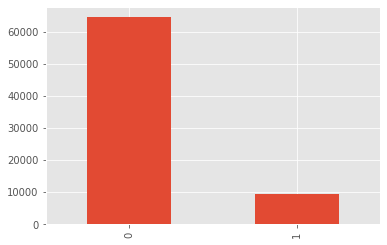

In [7]:
train['default'].value_counts().plot.bar()

Недефолтный клиентов банка больше чем дефолтных.

In [8]:
time_p = ['app_date'] # временной признак - 1
numeral_p = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income'] # числовой признак - 5
binar_p = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport'] # бинарный признак - 5
categoral_p = ['education', 'region_rating','home_address', 'work_address', 'sna', 'first_time'] # категоральный признак - 6

#### Числовые признаки

**decline_app_cnt**

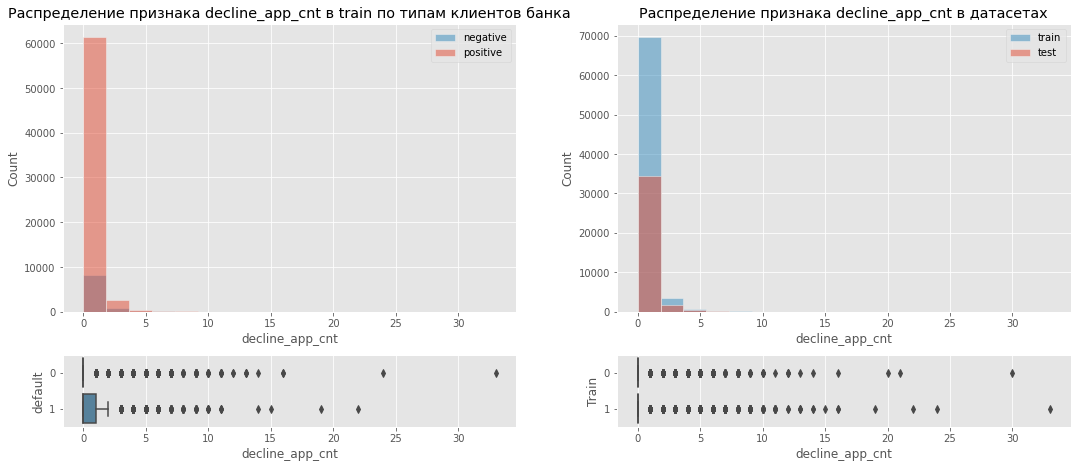

In [9]:
numeral('decline_app_cnt')

Выбросов много.
Распределение логнормальное.
Дефолтные клиенты банка имеют больше отказов в заявках.

**age**

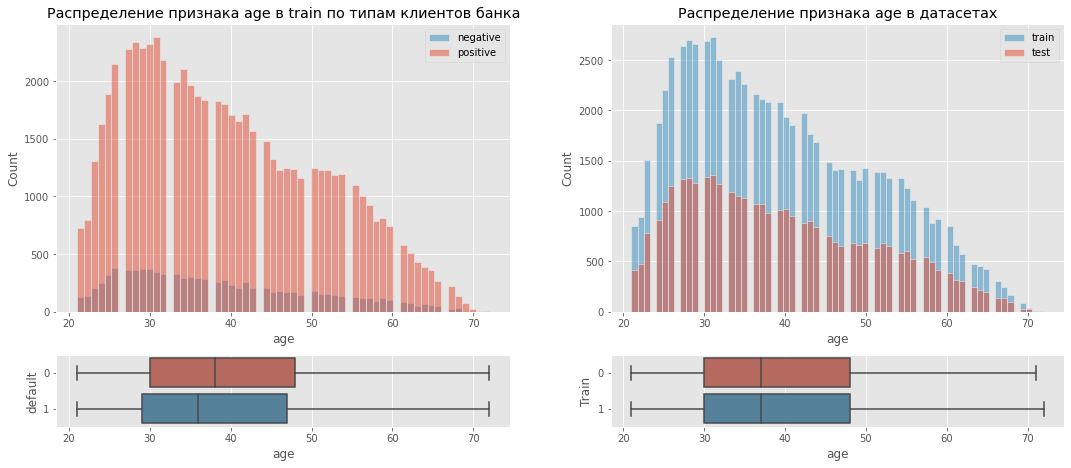

In [10]:
numeral('age')

Выбросов нет.
Распредленеие логнормальное.
Дефолтные клиенты банка относятся к молодому возрасту.

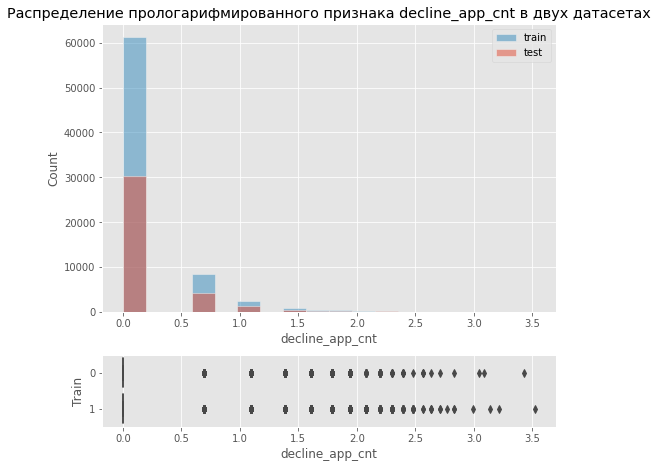

In [11]:
data['decline_app_cnt'] = np.log(data['decline_app_cnt'] + 1)
numeral_prolog('decline_app_cnt')

**score_bki**

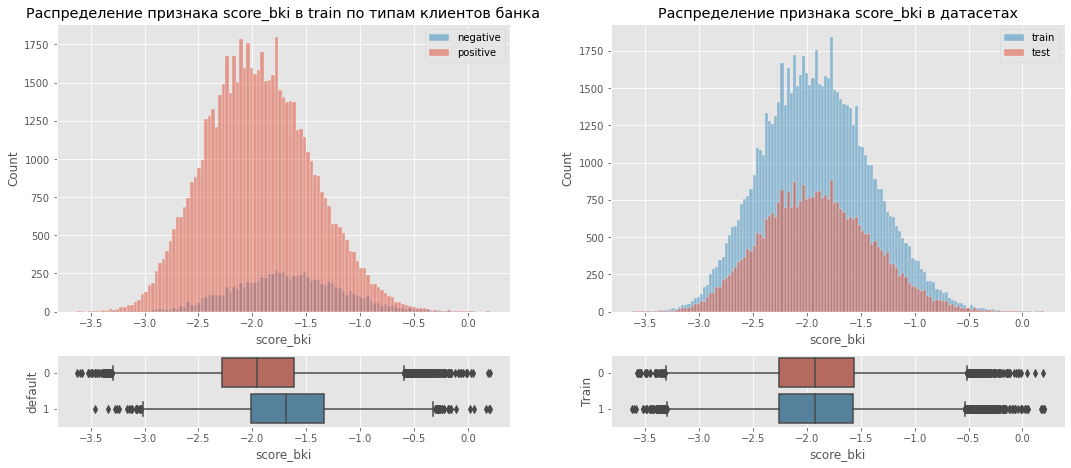

In [12]:
numeral('score_bki')

Распредление нормальное.
Выбросов мало.
Скорр балл выше у дефолтных клиентов банка.

**bki_request_cnt**

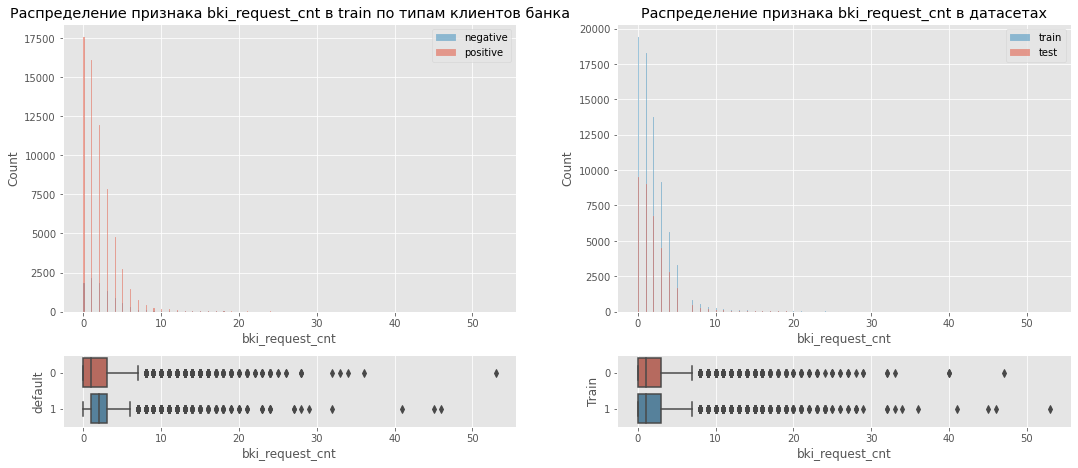

In [13]:
numeral('bki_request_cnt')

Распределение логнормальное.
Много выборосов.

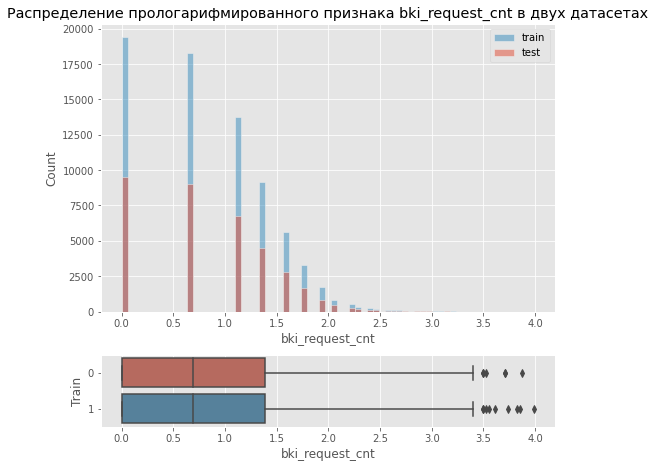

In [14]:
data['bki_request_cnt'] = np.log(data['bki_request_cnt'] + 1)
numeral_prolog('bki_request_cnt')

**income**

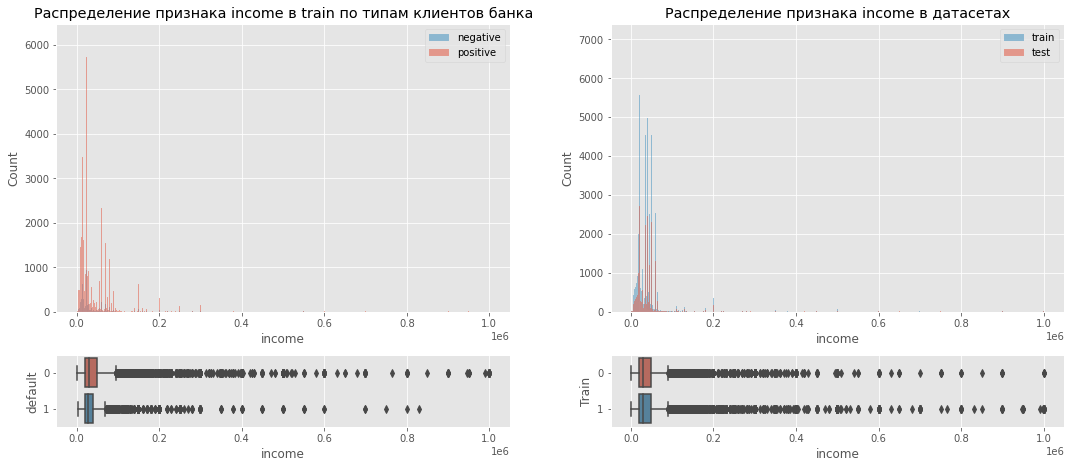

In [15]:
numeral('income')

Распределение логнормальное.
Выбросов много.
Клиенты с дефолтом имеют низкий доход.

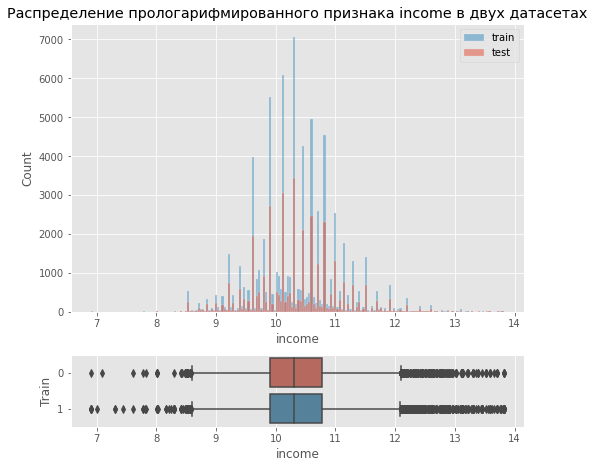

In [16]:
data['income'] = np.log(data['income'] + 1)
numeral_prolog('income')

#### Категоральные признаки

**education**

Как мы помним в этом признаке у нас есть пропуски, поэтому заменим пропуски на те что встречаются чаще значения.

In [17]:
data['education'].value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

Частое значение это SCH. Заполняем.

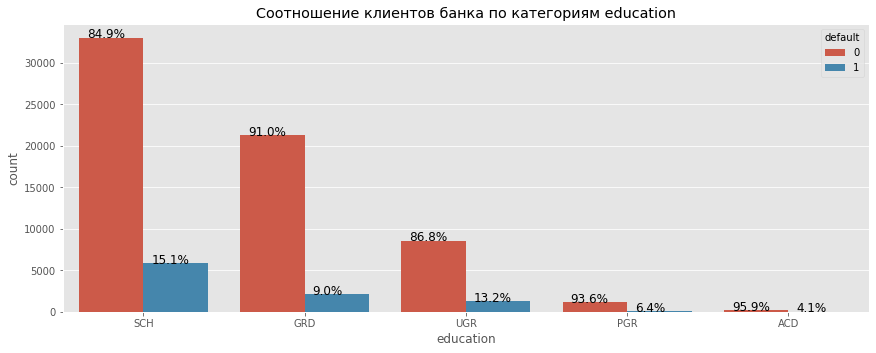

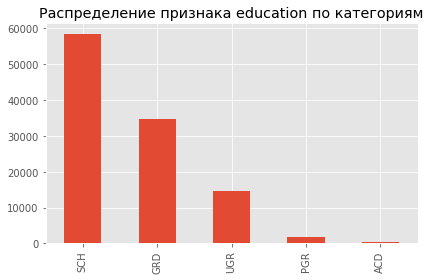

In [18]:
data['education'] = data['education'].fillna('SCH')
categoral('education')

Самые ненадежные банковские клиенты - учащиеся.
Менее ненадежные банковские клиенты - окончившие школу.
Надёжные - получающие высшее образование.
Самые надёжные - со степенями.

**home_address**

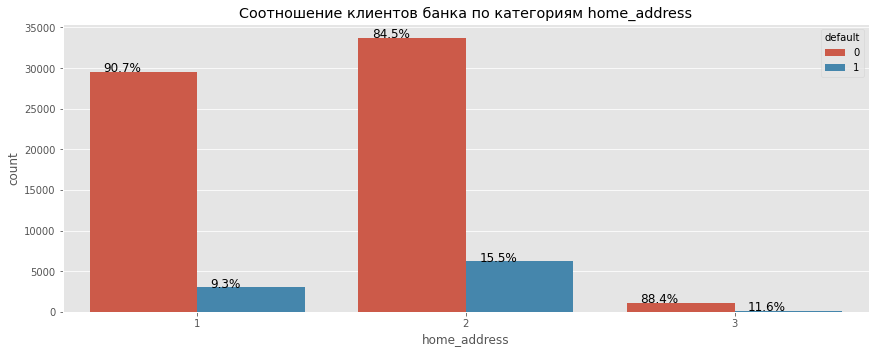

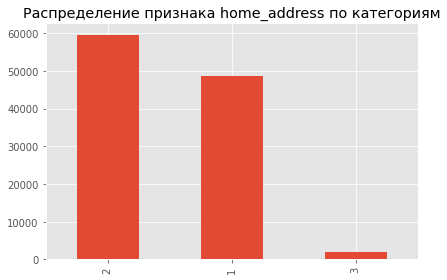

In [19]:
categoral('home_address')

Большая масса клиентов банка расположена в категориях 1 и 2. Разница между ними небольшая.

**region_rating**

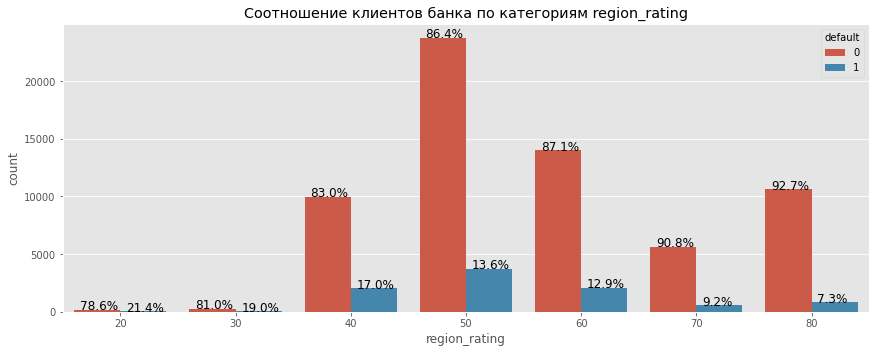

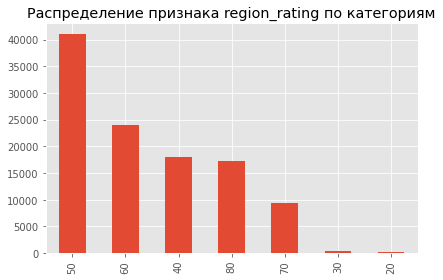

In [20]:
categoral('region_rating')

Чем выше рейтинг региона тем уменьшается сильнее число дефолтных клиентов.

**work_address**

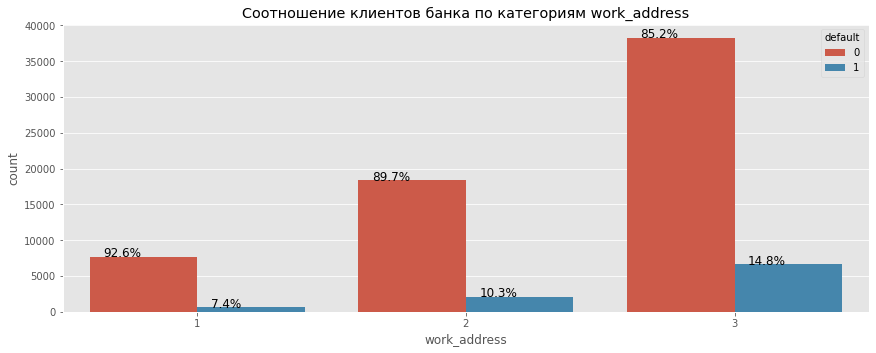

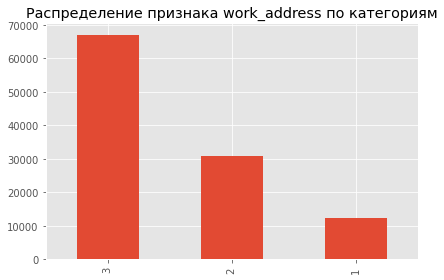

In [21]:
categoral('work_address')

**first_time**

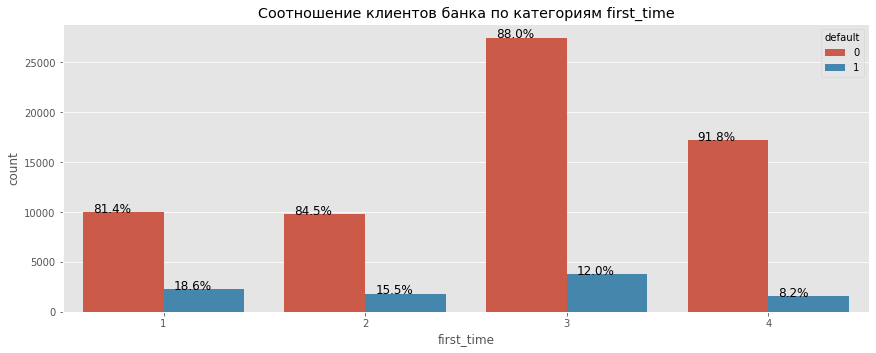

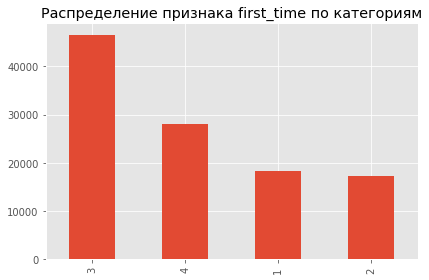

In [22]:
categoral('first_time')

Чем ниже признак - тем выше число дефолтных клиентов банка.

**sna**

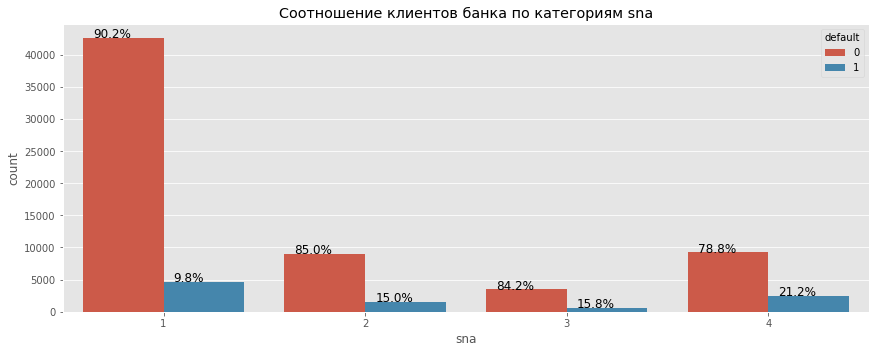

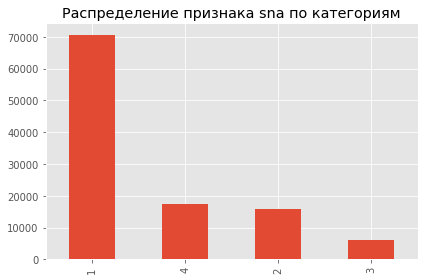

In [23]:
categoral('sna')

Чем выше признак - тем выше число дефолтных клиентов.

**sex**

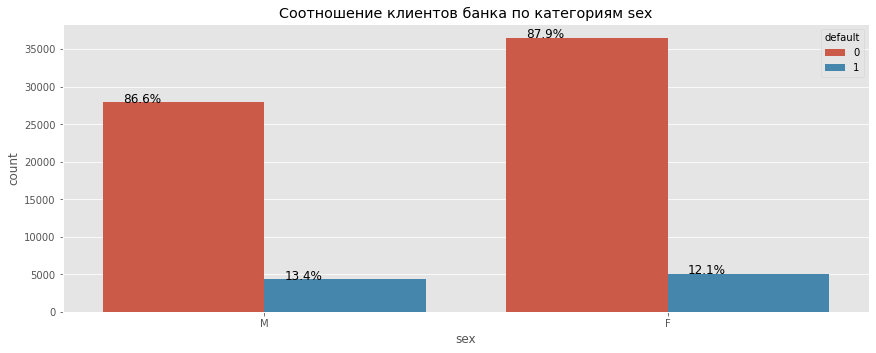

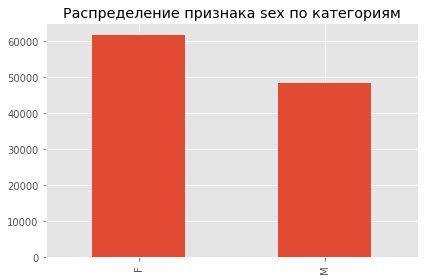

In [24]:
categoral('sex')

В датасете число женщин клиентов банка больше чем мужчин клиентов банка на 1\4. Число дефолтных клиентов и там и там почти равно.

**car**

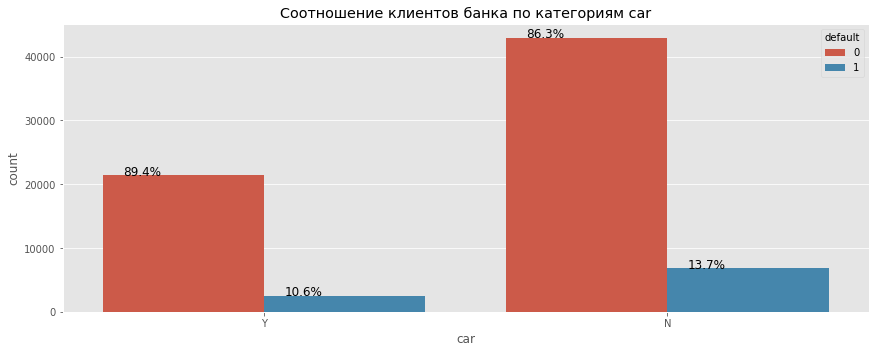

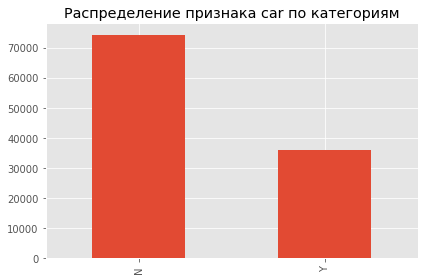

In [25]:
categoral('car')

Клиенты банка с автомобилем куда надёжнее тех у кого их нет.

**car_type**

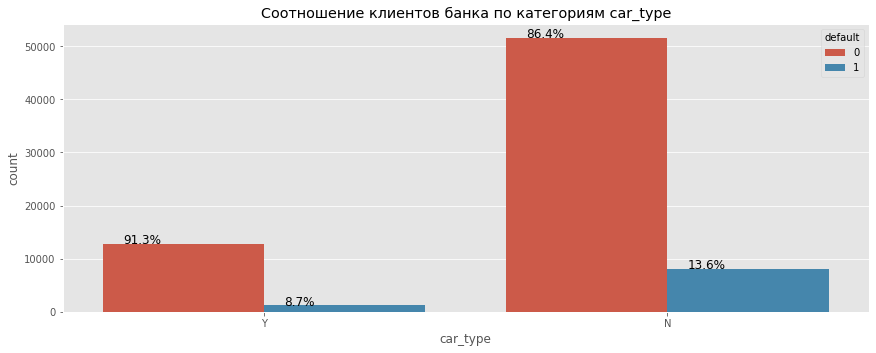

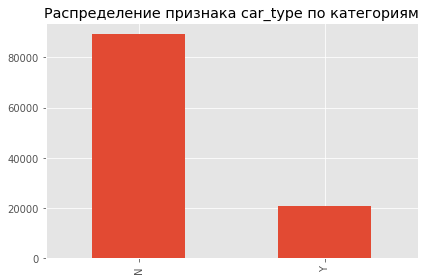

In [26]:
categoral('car_type')

Клиенты банка с иномаркой более надёжные.

**foreign_passport**

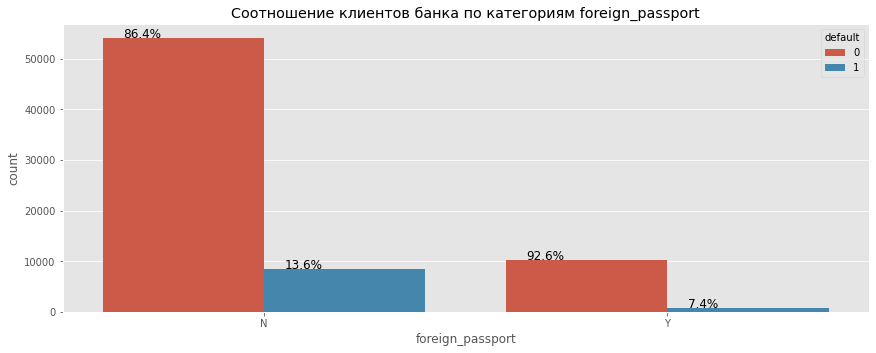

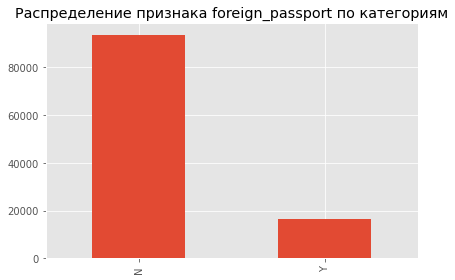

In [27]:
categoral('foreign_passport')

У тех клиентов банка, у которых есть загранпаспорт число кредитов меньше. Процент возврата кредита больше.

**good_work**

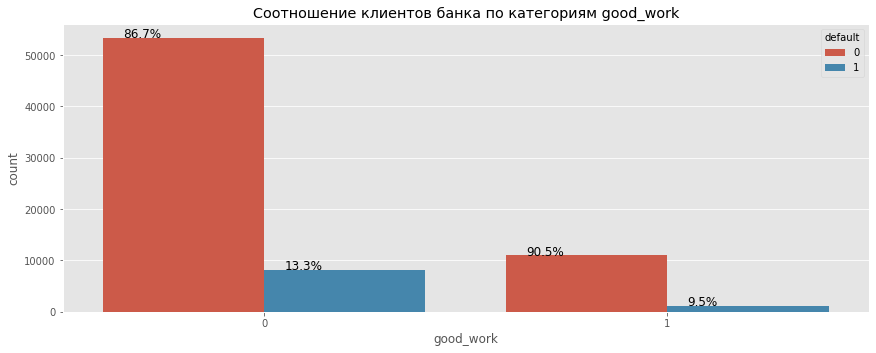

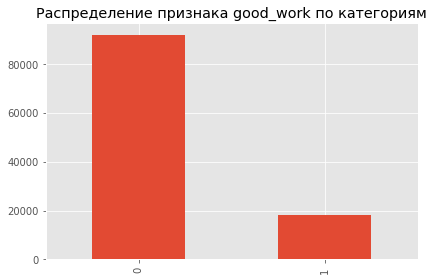

In [28]:
categoral('good_work')

Клиенты банка, у которых качественная и хорошая работа мало. Такие клиенты реже уходят в дефолт.

**app_date**

In [29]:
data.app_date = pd.to_datetime(data.app_date, format='%d%b%Y')
start_date = data.app_date.min()
end_date = data.app_date.max()
print(start_date, end_date)

2014-01-01 00:00:00 2014-04-30 00:00:00


In [30]:
data['days'] = (data.app_date - start_date).dt.days.astype('int')

#### Feature engineering

In [31]:
binar_colums = {}
label_encoder = LabelEncoder()
for col in binar_p:
    data[col] = label_encoder.fit_transform(data[col])
    binar_colums[col] = dict(enumerate(label_encoder.classes_))
print(binar_colums)

{'sex': {0: 'F', 1: 'M'}, 'car': {0: 'N', 1: 'Y'}, 'car_type': {0: 'N', 1: 'Y'}, 'good_work': {0: 0, 1: 1}, 'foreign_passport': {0: 'N', 1: 'Y'}}


In [32]:
edu_dict = {'SCH': 1,'UGR': 2,'GRD': 3,'PGR': 4,'ACD': 5}
edu = data.education.fillna(data.education.mode()[0]).map(edu_dict)
max_income = data.groupby('age')['income'].max().to_dict()
mean_income_region = data.groupby('region_rating')['income'].mean().to_dict()
mean_income_age = data.groupby('age').income.mean().to_dict()
mean_bki = data.groupby('age')['bki_request_cnt'].mean().to_dict()
data['priznak_1'] = data['age'].map(max_income)
data['priznak_2'] = data['region_rating'].map(mean_income_region)
data['priznak_3'] = data.income / data.region_rating
data['priznak_4'] = data.income / (data.bki_request_cnt + 1)
data['priznak_5'] = (data.decline_app_cnt * data.sna) ** 2
data['priznak_6'] = data.region_rating * data.car
data['priznak_7'] = (data.car + data.car_type) / data.sna * data.decline_app_cnt
data['priznak_8'] = data.home_address + data.work_address
data['priznak_9'] = data.income**2 / (data.region_rating * (data.decline_app_cnt + 1))
data['priznak_10'] = data.first_time * data.sna / (data.bki_request_cnt + 1)
data['priznak_11'] = (data.score_bki / data.age) ** data.foreign_passport
data['priznak_12'] = (data.score_bki / data.age) ** data.sna
data['priznak_13'] = data.age / data.score_bki
data['priznak_14'] = data.good_work * (data.home_address + data.work_address) 
data['priznak_15'] = (data.home_address + data.work_address) * data.sna 
data['priznak_16'] = data.decline_app_cnt * data.sna
data['priznak_17'] = abs((data.income - data.age.map(mean_income_age))/data['age'].map(max_income))
data['priznak_18'] = data['age'].map(mean_bki)
data['priznak_19'] = (data.bki_request_cnt!=0).astype(int)
data['priznak_20'] = (data.decline_app_cnt==0).astype(int)
data['priznak_21'] = data.client_id.lt(10000).astype(int)
data['priznak_22'] = data.client_id.between(10000,90000).astype(int)
data['priznak_23'] = np.log(data.decline_app_cnt/data.client_id +1)
data['priznak_24'] = np.log((data.income/data.age)+1)
data['priznak_25'] = np.log((edu/data.age)+1)
my_numeral = list(data.columns[data.columns.str.contains('priznak')])

#### Нормализация данных

In [33]:
numeral_columns = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'days']
scaler = StandardScaler()
for col in numeral_columns:
    data[col] = scaler.fit_transform(data[[col]])
for col in my_numeral:
    data[col] = scaler.fit_transform(data[[col]])

In [34]:
data=pd.get_dummies(data, prefix=categoral_p, columns=categoral_p)
data.head()

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,Train,days,priznak_1,priznak_2,priznak_3,priznak_4,priznak_5,priznak_6,priznak_7,priznak_8,priznak_9,priznak_10,priznak_11,priznak_12,priznak_13,priznak_14,priznak_15,priznak_16,priznak_17,priznak_18,priznak_19,priznak_20,priznak_21,priznak_22,priznak_23,priznak_24,priznak_25,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
0,25905,2014-02-01,1,1.975219,1,1,-0.418815,0,-2.008753,-0.281790,-0.786080,0,0.0,1,-0.934391,-2.296030,-0.587943,0.105112,-0.215311,-0.199072,1.104695,-0.185170,-0.948864,0.172040,-0.104565,0.418574,1.100701,-0.268003,-0.424894,0.871743,-0.342548,-0.895842,0.226195,0.596519,0.451868,-0.315977,0.613867,-0.023902,-1.568152,-1.119981,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0
1,63161,2014-03-12,0,1.714757,0,0,-0.418815,0,-1.532276,0.770563,-0.708472,0,0.0,1,0.281474,0.654775,-0.587943,0.129718,-0.865709,-0.199072,-0.668956,-0.185170,0.820066,0.209797,-0.472532,0.418574,1.100679,-0.515153,-0.424894,2.326493,-0.342548,-0.862382,0.359502,0.596519,0.451868,-0.315977,0.613867,-0.023902,-1.451676,-1.093218,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0
2,25887,2014-02-01,1,-1.237142,1,0,2.621662,0,-1.408142,-0.281790,-0.052834,1,0.0,1,-0.934391,-0.521607,1.872131,-1.421836,-0.096985,0.100990,2.168885,4.050438,-0.948864,-2.115094,-0.104565,-2.394190,-0.787635,0.156139,-0.424894,-0.764850,0.955208,-1.180574,-0.508472,0.596519,-2.213034,-0.315977,0.613867,0.042369,1.434824,-0.349713,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1
3,16222,2014-01-23,0,1.193834,0,0,-0.418815,0,-2.057471,0.333797,-1.629771,0,0.0,1,-1.214975,0.786083,-0.587943,-0.162379,-0.763678,-0.199072,-0.668956,-0.185170,0.820066,-0.225018,-0.604829,0.418574,-0.200770,-0.102851,-0.424894,-0.401163,-0.342548,1.250336,0.608238,0.596519,0.451868,-0.315977,0.613867,-0.023902,-1.363864,-1.030688,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0
4,101655,2014-04-18,1,0.759731,0,0,-0.418815,1,-1.244723,-0.281790,-0.052834,1,0.0,1,1.434987,0.516365,-0.288111,-0.444378,-0.096985,-0.199072,-0.668956,-0.185170,0.820066,-0.092438,-0.104565,-2.313257,0.231312,-0.517029,2.749057,-0.401163,-0.342548,-0.951625,0.686752,0.596519,0.451868,-0.315977,-1.629017,-0.023902,-0.844691,0.360299,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1


In [35]:
data.corr()

,client_id,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,Train,days,priznak_1,priznak_2,priznak_3,priznak_4,priznak_5,priznak_6,priznak_7,priznak_8,priznak_9,priznak_10,priznak_11,priznak_12,priznak_13,priznak_14,priznak_15,priznak_16,priznak_17,priznak_18,priznak_19,priznak_20,priznak_21,priznak_22,priznak_23,priznak_24,priznak_25,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
client_id,1.000000,-0.033333,0.015535,-0.022271,-0.024695,-0.022520,0.003447,-0.061653,-0.008626,0.002900,-0.013739,-0.039242,0.002844,0.999581,0.012402,0.003766,-0.005449,-0.005555,-0.015603,-0.018697,-0.014065,0.175770,0.009720,-0.006657,0.013394,-0.019415,0.011162,0.022398,0.053947,-0.020644,-0.021052,0.004893,0.019764,0.018923,-0.497606,-0.259976,-0.033968,-0.016814,0.026718,-0.000222,0.031792,-0.002091,-0.050430,0.031338,0.003024,-0.004653,-0.008062,0.003060,0.001381,-0.002338,0.004711,-0.182347,0.190167,-0.032556,-0.078084,-0.140950,0.179965,0.006758,-0.010024,-0.003767,0.003123,0.009287,-0.021229,-0.024239,0.037276
sex,-0.033333,1.000000,-0.134411,0.277470,0.224822,0.022335,-0.044026,-0.046214,-0.052160,0.305326,0.085924,0.019619,-0.005135,-0.033811,0.017899,0.109298,-0.015378,0.096435,0.015030,0.274942,0.082145,0.060607,0.041525,0.031825,-0.086482,-0.046865,0.040111,-0.031455,0.016261,0.021107,-0.017486,-0.016907,-0.032048,-0.021847,0.024731,-0.000830,0.002363,0.178020,0.070921,0.017238,0.022769,0.019994,-0.040150,0.017589,-0.023470,-0.012078,-0.051163,-0.043214,-0.006790,0.045934,0.087714,-0.036289,0.033477,0.010375,-0.062010,-0.022596,0.060769,-0.000473,0.008966,-0.004159,-0.005375,-0.015820,0.006459,-0.002517,0.010985
age,0.015535,-0.134411,1.000000,-0.048263,-0.044402,-0.121932,-0.072233,-0.104682,0.045198,-0.117274,-0.040238,-0.025004,0.003864,0.015831,0.215850,-0.087010,0.051401,-0.054703,-0.080210,-0.052625,-0.054963,0.002920,0.088015,-0.051125,0.044801,0.184582,-0.195759,-0.076042,-0.043039,-0.114208,0.101115,0.299184,0.021006,0.114439,-0.021252,-0.000511,-0.009558,-0.953060,-0.529329,0.004797,-0.069744,-0.007772,0.168704,-0.149820,0.012867,0.010163,0.049155,0.038578,-0.007366,-0.047778,-0.060083,-0.011618,0.010311,0.004894,0.010520,-0.007846,0.000430,0.094354,-0.079816,-0.061850,-0.008311,-0.012392,-0.075937,-0.021080,0.097870
car,-0.022271,0.277470,-0.048263,1.000000,0.698760,-0.039005,0.001565,-0.043080,-0.045470,0.323183,0.106893,-0.043161,-0.002382,-0.022468,0.063707,0.061221,0.033704,0.103386,-0.028734,0.962875,0.266528,-0.016380,0.122550,0.024427,-0.106866,-0.075589,0.024621,0.003193,-0.072363,-0.041725,0.081295,0.015274,-0.045058,0.039715,0.012132,0.013044,-0.003258,0.085762,0.114353,0.023503,0.109157,0.066957,-0.119598,-0.002624,-0.010881,-0.011222,-0.029880,-0.026220,0.001092,0.023280,0.049803,0.025902,-0.026069,0.000984,-0.004355,0.019000,-0.014662,0.064902,-0.008561,-0.018171,-0.065529,-0.079398,-0.022534,0.026573,0.056512
car_type,-0.024695,0.224822,-0.044402,0.698760,1.000000,-0.050902,0.016160,-0.042107,-0.016938,0.369761,0.145373,-0.057484,-0.003309,-0.024865,0.058026,0.114127,0.013581,0.090399,-0.037425,0.700693,0.232888,-0.004550,0.125400,0.007024,-0.145523,-0.087918,0.022433,0.019002,-0.079859,-0.053270,0.141800,0.016028,-0.033117,0.050693,0.015278,0.008852,-0.004821,0.094953,0.155305,0.033088,0.153081,0.086565,-0.157802,-0.015459,-0.011590,-0.011721,-0.032034,-0.051686,-0.024867,0.051977,0.093662,0.011631,-0.011246,-0.001336,-0.001172,-0.000149,0.000893,0.078137,-0.013672,-0.021906,-0.075641,-0.087207,-0.025082,0.024861,0.067254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [36]:
data = data.drop(['app_date', 'education_GRD', 'good_work', 'region_rating_80', 'sna_3', 'home_address_2', 'education_ACD', 'sna_4'], axis=1)

In [37]:
data.head()

,client_id,sex,age,car,car_type,decline_app_cnt,score_bki,bki_request_cnt,income,foreign_passport,default,Train,days,priznak_1,priznak_2,priznak_3,priznak_4,priznak_5,priznak_6,priznak_7,priznak_8,priznak_9,priznak_10,priznak_11,priznak_12,priznak_13,priznak_14,priznak_15,priznak_16,priznak_17,priznak_18,priznak_19,priznak_20,priznak_21,priznak_22,priznak_23,priznak_24,priznak_25,education_PGR,education_SCH,education_UGR,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,home_address_1,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,first_time_1,first_time_2,first_time_3,first_time_4
0,25905,1,1.975219,1,1,-0.418815,-2.008753,-0.281790,-0.786080,0,0.0,1,-0.934391,-2.296030,-0.587943,0.105112,-0.215311,-0.199072,1.104695,-0.185170,-0.948864,0.172040,-0.104565,0.418574,1.100701,-0.268003,-0.424894,0.871743,-0.342548,-0.895842,0.226195,0.596519,0.451868,-0.315977,0.613867,-0.023902,-1.568152,-1.119981,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0
1,63161,0,1.714757,0,0,-0.418815,-1.532276,0.770563,-0.708472,0,0.0,1,0.281474,0.654775,-0.587943,0.129718,-0.865709,-0.199072,-0.668956,-0.185170,0.820066,0.209797,-0.472532,0.418574,1.100679,-0.515153,-0.424894,2.326493,-0.342548,-0.862382,0.359502,0.596519,0.451868,-0.315977,0.613867,-0.023902,-1.451676,-1.093218,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0
2,25887,1,-1.237142,1,0,2.621662,-1.408142,-0.281790,-0.052834,1,0.0,1,-0.934391,-0.521607,1.872131,-1.421836,-0.096985,0.100990,2.168885,4.050438,-0.948864,-2.115094,-0.104565,-2.394190,-0.787635,0.156139,-0.424894,-0.764850,0.955208,-1.180574,-0.508472,0.596519,-2.213034,-0.315977,0.613867,0.042369,1.434824,-0.349713,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1
3,16222,0,1.193834,0,0,-0.418815,-2.057471,0.333797,-1.629771,0,0.0,1,-1.214975,0.786083,-0.587943,-0.162379,-0.763678,-0.199072,-0.668956,-0.185170,0.820066,-0.225018,-0.604829,0.418574,-0.200770,-0.102851,-0.424894,-0.401163,-0.342548,1.250336,0.608238,0.596519,0.451868,-0.315977,0.613867,-0.023902,-1.363864,-1.030688,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0
4,101655,1,0.759731,0,0,-0.418815,-1.244723,-0.281790,-0.052834,1,0.0,1,1.434987,0.516365,-0.288111,-0.444378,-0.096985,-0.199072,-0.668956,-0.185170,0.820066,-0.092438,-0.104565,-2.313257,0.231312,-0.517029,2.749057,-0.401163,-0.342548,-0.951625,0.686752,0.596519,0.451868,-0.315977,-1.629017,-0.023902,-0.844691,0.360299,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1


#### Построение модели

In [38]:
train_data = data.query('Train == 1').drop(['Train', 'client_id'], axis=1)
test_data = data.query('Train == 0').drop(['Train', 'client_id', 'default'], axis=1)
y = train_data.default.values
X = train_data.drop(['default'], axis=1)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#### Обучение модели

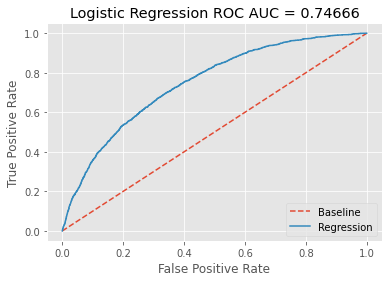

In [40]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [41]:
print('accuracy_score:', accuracy_score(y_test, y_pred))
print('precision_score:', precision_score(y_test, y_pred))
print('recall_score:', recall_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred))
print('roc_auc:', roc_auc_score(y_test, y_pred_proba))

accuracy_score: 0.8754065040650406
precision_score: 0.4387755102040816
recall_score: 0.02353585112205802
f1_score: 0.04467532467532468
roc_auc: 0.746664157841659


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

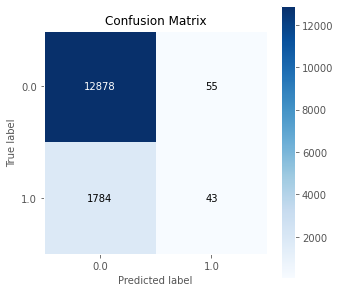

In [42]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(5, 5))

Правим нашу модель предсказаний.

**Настройка параметров**

In [43]:
#C = [0.1, 1, 10]
#penalty = ['l2']
#solver = ['newton-cg','liblinear','sag', 'saga', 'lbfgs']
#class_weight = ['balanced', {1:0.7, 0:0.3}]
#param = dict(penalty=penalty, solver=solver, class_weight=class_weight, C=C)
#gridsearch = GridSearchCV(model, param_grid=param, scoring='f1', n_jobs=-1, cv=5)
#grid_result = gridsearch.fit(X_train, y_train)
#print('Best Score: ', grid_result.best_score_)
#print('Best Params: ', grid_result.best_params_)

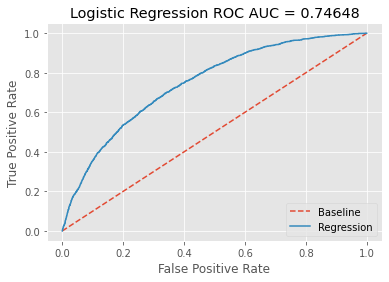

In [44]:
model = LogisticRegression(random_state=42, C=10, penalty='l2', class_weight={
                            1: 0.7, 0: 0.3}, solver='newton-cg', max_iter=10000)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [45]:
print('accuracy_score:', accuracy_score(y_test, y_pred))
print('precision_score:', precision_score(y_test, y_pred))
print('recall_score:', recall_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred))
print('roc_auc:', roc_auc_score(y_test, y_pred_proba))

accuracy_score: 0.8557588075880759
precision_score: 0.36222627737226276
recall_score: 0.21729611384783798
f1_score: 0.2716387273349299
roc_auc: 0.7464810322375972


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

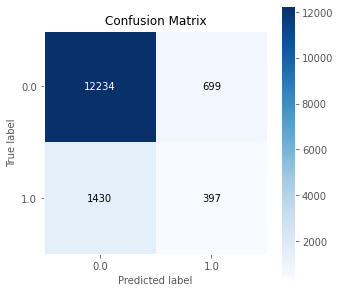

In [46]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(5, 5))

**Вывод:** при ситуации когда наша целевая переменная была несбалансированна у нас получались низкие значения у f1-score метрики. Оптимизировав гиперпараметры мы приводим матрицу к удобному виду и улучшению f1-score метрики.

#### Submit

In [47]:
predict_submission = model.predict_proba(test_data)[:,1]
predict_submission

array([0.08247734, 0.50648494, 0.14884863, ..., 0.47600604, 0.43231059,
       0.42715255])

In [48]:
for_ids = pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')

In [49]:
sample_submission = pd.DataFrame(columns = ['client_id','default'])
sample_submission['client_id'] = for_ids.client_id
sample_submission['default'] = predict_submission
sample_submission

,client_id,default
0,74835,0.082477
1,17527,0.506485
2,75683,0.148849
3,26883,0.167250
4,28862,0.047134
...,...,...
36344,83775,0.567145
36345,106254,0.039441
36346,81852,0.476006
36347,1971,0.432311


In [50]:
sample_submission.to_csv('submission.csv', index=False)